# BAI Data Science Case Study (Heart)

### Author: Keith Dowd

We are  interested in understanding what are the main contributing factors toward heart disease. We have been given a patient-level dataset that measures key demographic and health outcomes for a given patient. This dataset has been flagged whether or not that patient was ultimately diagnosed with heart disease in the target column. We have also been provided a data dictionary in the Heart_Disease_Patient_Data_Dictionary tab.

## Questions

1. Use a predictive model to identify the main contributing factors towards heart disease. 
2. Put together a mock up visual to share the results of your analysis. Be prepared to discuss which model(s) you used and why.

## Methdology

1. Review descriptive statistics for the data:
   - Of particular interest are the correlations between the predictors and target.
2. Fit data to a variety of models:
   - Use results to select two modeling approaches.
3. Select two different modeling approaches for further investigation:
   - In this case, logistic regression and extra-trees classifier.
   - Both report similar model fit scores.
   - Each uses a different approach (regression vs. trees) for modeling.
4. Fit data using 10-fold cross-validation:
   - Confirm model fit scores on train vs. test.
5. Fit all data and extract feature importance:
   - Coefficients for logistic regression and feature importance scores for extra-trees classifier.
6. Compare feature importance across two modeling approaches:
   - Rank order feature importance.
7. Bonus: Univariate feature selection!


In [1]:
from functools import partial
import os

from lazypredict.Supervised import LazyClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from ydata_profiling import ProfileReport

In [2]:
# Plot figures inline to notebook
%matplotlib inline

# Set seaborn figure style theme
sns.set_style("darkgrid")

## Setup

Let's read the data for the analysis into a Pandas dataframe.

In [3]:
def load_data(data):
    """Convenience function to load CSV data into a Pandas dataframe."""
    return pd.read_csv(data)

In [4]:
# Read data into Pandas dataframe
df = load_data(os.path.join(os.getcwd(), '..', 'data', 'raw', 'BAI Data Science Case Study_Heart.csv'))

## Descriptives

Let's generate descriptive statistics to learn more about the data before diving into a modeling exercise.

### Key takeaways
* No observations missing (do not need to consider imputation).
* Relatively even balance between classes in the __target__ outcome variable.
* Features with largest correlation with target include: __exang__, __cp__, __oldpeak__, __thalach__, __ca__, and __thal__

### Basics
* There are 303 observations in the data.
* There are 14 dimensions in the data - 13 predictors, 1 target.
* There is 1 observation that is duplicated twice - I'll assume this duplication is a natural sampling occurrence.

### Missing data
* There are no observations missing data.

### Target
* There is a relatively even balance of classes in the target dimension. No need to consider class imbalance related issues.

### Predictors
* __age__: Normally distributed, with a mean of 54. A few outliers (e.g., 29 year old, 77 year old).
* __sex__: Twice as many male relative to females.
* __cp__: About an equal number of patients reporting no chest pain vs. some kind of chest pain (assuming `cp=0` is no chest pain).
* __trestbps__: Mean of 131 (median of 131). Very slightly right skewed.
* __chol__: Mean of 246. A few outliers in the 400s. One observation is in the 500s.
* __fbs__: Most observations (86%) report fasting blood sugar <120 mg/dl.
* __restecg__: Most observations report resting electrocardiographic results with a value of 1 or 0. Four observations report a value of 2.
* __thalach__: Mean of 150. Slightly right-skewed distribution.
* __exang__: Two-thirds of observations are 0.
* __oldpeak__: 33% of observations are 0.
* __slope__: Most observations are 1 or 2.
* __ca__: Most observations are 0.
* __thal__: Most observations are 2 or 3.

In [5]:
# Create a profile instance
profile = ProfileReport(df, title="BAI Data Science Case Study_Heart")

# Render profile inline to notebook
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Correlations

Let's print out correlation of each predictor feature with the outcome variable, `target`, and sort the correlations in descending order.

In [6]:
df_correlations = df.corr()
df_correlations

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.00,-0.10,-0.07,0.28,0.21,0.12,-0.12,-0.40,0.10,0.21,-0.17,0.28,0.07,-0.23
sex,-0.10,1.00,-0.05,-0.06,-0.20,0.05,-0.06,-0.04,0.14,0.10,-0.03,0.12,0.21,-0.28
cp,-0.07,-0.05,1.00,0.05,-0.08,0.09,0.04,0.30,-0.39,-0.15,0.12,-0.18,-0.16,0.43
trestbps,0.28,-0.06,0.05,1.00,0.12,0.18,-0.11,-0.05,0.07,0.19,-0.12,0.10,0.06,-0.14
chol,0.21,-0.20,-0.08,0.12,1.00,0.01,-0.15,-0.01,0.07,0.05,-0.00,0.07,0.10,-0.09
fbs,0.12,0.05,0.09,0.18,0.01,1.00,-0.08,-0.01,0.03,0.01,-0.06,0.14,-0.03,-0.03
restecg,-0.12,-0.06,0.04,-0.11,-0.15,-0.08,1.00,0.04,-0.07,-0.06,0.09,-0.07,-0.01,0.14
thalach,-0.40,-0.04,0.30,-0.05,-0.01,-0.01,0.04,1.00,-0.38,-0.34,0.39,-0.21,-0.10,0.42
exang,0.10,0.14,-0.39,0.07,0.07,0.03,-0.07,-0.38,1.00,0.29,-0.26,0.12,0.21,-0.44
oldpeak,0.21,0.10,-0.15,0.19,0.05,0.01,-0.06,-0.34,0.29,1.00,-0.58,0.22,0.21,-0.43


In [7]:
np.abs(df_correlations["target"][0:13]).sort_values(ascending=False)

exang      0.44
cp         0.43
oldpeak    0.43
thalach    0.42
ca         0.39
slope      0.35
thal       0.34
sex        0.28
age        0.23
trestbps   0.14
restecg    0.14
chol       0.09
fbs        0.03
Name: target, dtype: float64

## Modeling

First, let's split the data into a training set (80% of data) and testing set (20% of data).

### Key takeaways
*  Many of the simple models fit to the data report a high accuracy score and other model fit metrics.
*  For simplicity, the following two models are selected for further experimentation because they (1) report good model fit and (2) allow for easy extraction of feature importance:
   - Logistic Regression (Accuracy score: 85%; F1 score: 85%)
   - Extra-trees Classifier (Accuracy score: 85%; F1 score: 85%)
 
### Notes
* There are other models we could have explored to determine feature importance. For example, an ElasticNet model is a good choice for feature selection.

In [8]:
# Features
X = df.iloc[:, 0:13]

# Target
y = df[['target']]

# Features (training), features (testing), target (training), target (testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next, let's quickly fit several models and identify a few high performing models for further experimentation.

In [9]:
# LazyClassifer is a Python package for quickly fitting an assortment of models to data
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit models
models, _ = clf.fit(X_train, X_test, y_train, y_test)

# Review model performance
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 36.87it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.90,0.90,0.90,0.90,0.02
RidgeClassifierCV,0.89,0.88,0.88,0.89,0.02
CalibratedClassifierCV,0.89,0.88,0.88,0.89,0.04
GaussianNB,0.87,0.87,0.87,0.87,0.01
NuSVC,0.87,0.87,0.87,0.87,0.02
SVC,0.87,0.87,0.87,0.87,0.02
BernoulliNB,0.87,0.87,0.87,0.87,0.01
LinearDiscriminantAnalysis,0.87,0.87,0.87,0.87,0.01
RidgeClassifier,0.87,0.87,0.87,0.87,0.02


## Model Fitting & Feature Importance
Now let's fit the data using the two modeling approaches identified in the previous step: `LogisticRegression` and `ExtraTreesClassifier`.

**The decision to fit the data to two models is to determine whether both of the fitted models identify the same features as the most important.**
* Also, two different algorithms are used for comparison - regression-based approach and tree-based approach, respectively.

### Key takeaways
* The top 5 most important features for predicting the __target__ outcome identified by the logistic regression model are: __ca__, __thal__, __cp__, __sex__, and __exang__
* The top 5 most important features for prediting the __target__ outcome identified by the extra-trees model are: __ca__, __cp__, __thal__, __exang__, and __thalach__
* In general, the two models are relatively consistent in the features identified as the most important for predicting the __target__ outcome.
* Specifically, __cp__, __ca__, __thal__, and __exang__ are important features (in top 5) identified by both models.

In [10]:
def cross_validation(model, X, y, cv=10):
    """Convenience function to fit a model to data (X, y) using (cv) cross validation."""
    res = cross_validate(
        estimator=model, 
        X=X, 
        y=y, 
        cv=cv,
        scoring=['accuracy'],
        return_train_score=True,
        return_estimator=True,
        n_jobs=-1)
    return res

In [11]:
def print_results(model_results):
    """Convenience function to print results from cross-validation function."""
    print(f'Mean training accuracy: {np.round(model_results["train_accuracy"].mean(), 3) * 100}%')
    print(f'Mean test accuracy: {np.round(model_results["test_accuracy"].mean(), 3) * 100}%')

In [12]:
def plot_feature_importance(feature_importance, feature_names, pos=False, sort=False, title=None, size=(10, 9)):
    """Convenience function to plot feature importances."""
    if pos == True:
        feature_importance = np.abs(feature_importance)
    data = pd.DataFrame({
        "Feature Importance": feature_importance, 
        "Feature Name": feature_names})
    if sort == True:
        data = data.sort_values('Feature Importance', ascending=False)
    sns.set(rc={"figure.figsize": size})
    p = sns.barplot(data=data, x="Feature Name", y="Feature Importance")
    plt.title(title)
    for i in p.containers:
        p.bar_label(i,)

### Logistic regression

First, let's fit the data to a logistic regression classifer model, which includes:

1. Preprocess the feature predictors for preparation to fit LR model to data.
2. Instantiate a logistic regression classifier model
3. Fit data to model using a 10-fold cross validation model and print mean training/test accuracy
4. Fit all data to model
5. Extract and plot feature importances (i.e., coefficients)

In [13]:
# Preprocess data in preparation to fit logistic regression model to data
X_cont = ["age", "trestbps", "chol", "thalach", "oldpeak"]
X_cat = ["cp", "slope", "ca", "thal"]
X_bin = ["sex", "fbs", "restecg", "exang"]

# Scale continuous features
scaler = StandardScaler()
scaler.fit(X[X_cont])
X_cont_scaled = pd.DataFrame(scaler.transform(X[X_cont]), columns=X_cont)

# One hot encode categorical features
one_hot_encoder = OneHotEncoder(drop="first") # Drop first category
one_hot_encoder.fit(X[X_cat])
X_cat_encoded = pd.DataFrame(one_hot_encoder.transform(X[X_cat]).toarray(), columns=one_hot_encoder.get_feature_names_out())

# Join all tranformed features back together
X_scaled = pd.concat([X_cont_scaled, X_cat_encoded, X[X_bin]], axis=1)

In [14]:
# Instantiate a logistic regression classifer model
lr_model = LogisticRegression(penalty=None, random_state=42) # Remove penalty term

In [15]:
# Fit logistic regression classifier model using cross-validation to all data
lr_cv_results = cross_validation(lr_model, X_scaled, y)

In [16]:
# Print cross-validation results
print_results(lr_cv_results)

Mean training accuracy: 88.8%
Mean test accuracy: 83.8%


In [17]:
# Fit logistic regression classifier model to all data 
lr_model_fit = lr_model.fit(X_scaled, y) # Use scaled data for regression models

In [18]:
# Extract feature importance scores
lr_model_feature_importance = lr_model_fit.coef_[0]

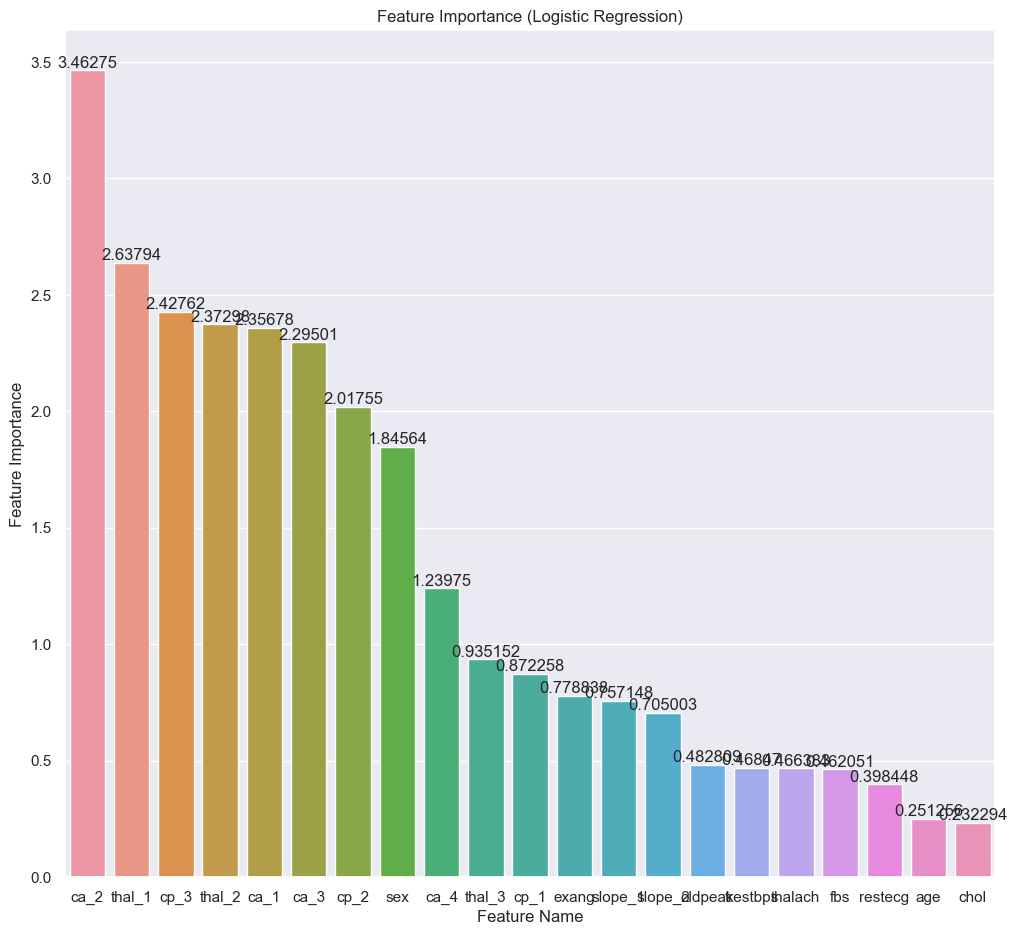

In [19]:
# Plot feature importance scores
plot_feature_importance(lr_model_feature_importance, X_scaled.columns[0:21], pos=True, sort=True, title="Feature Importance (Logistic Regression)", size=(12, 11))

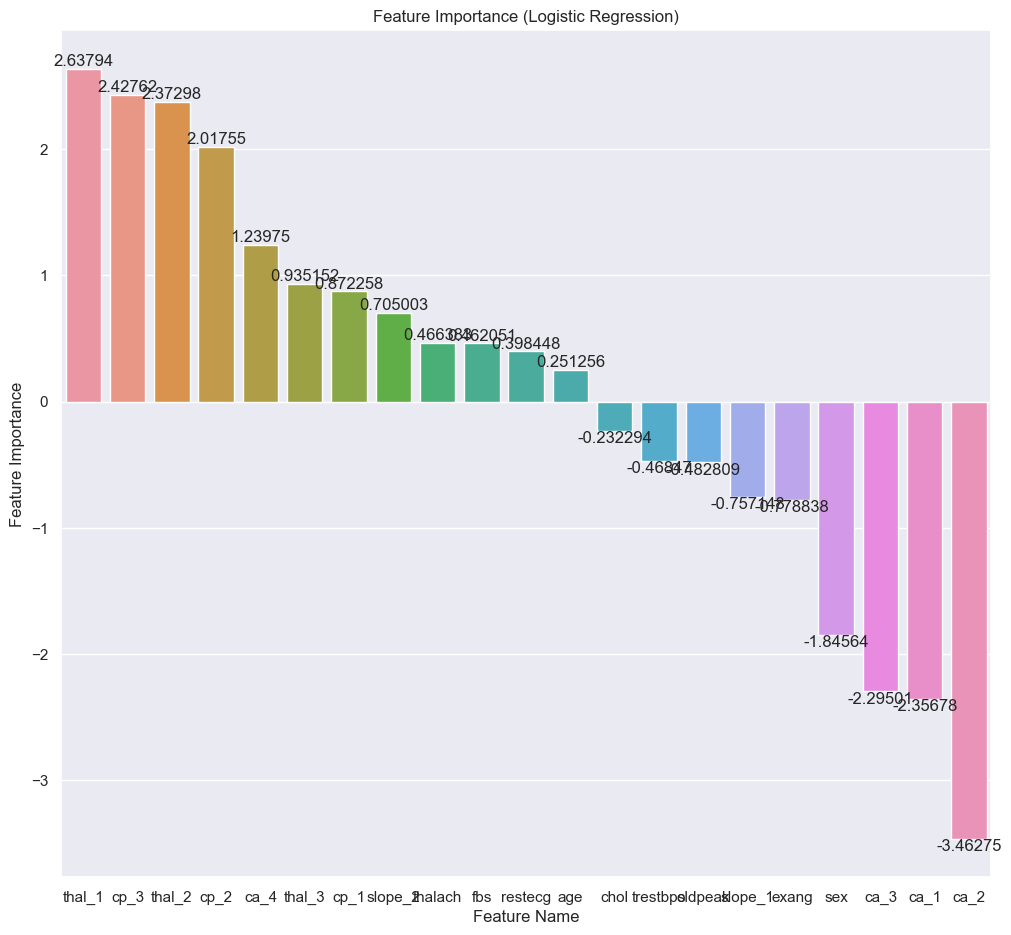

In [20]:
# Plot feature importance scores (sorted, only)
plot_feature_importance(lr_model_feature_importance, X_scaled.columns[0:21], pos=False, sort=True, title="Feature Importance (Logistic Regression)", size=(12, 11))

### Extra-trees classifier

Now, let's fit the data to an extra-trees classifer model, which includes:

1. Scale the feature predictors to mean=0 and standard deviation=1
2. Instantiate an extra-trees classifier model
3. Fit data to model using a 10-fold cross validation model and print mean training/test accuracy
4. Fit all data to model
5. Extract and plot feature importances

In [21]:
# Instantiate an extra-trees classifer model
et_model = ExtraTreesClassifier(random_state=42)

In [22]:
# Fit extra-trees classifier model using cross-validation to all data
et_cv_results = cross_validation(et_model, X, y) # Don't use scaled data (no need for tree models)

In [23]:
# Print cross-validation results
print_results(et_cv_results)

Mean training accuracy: 100.0%
Mean test accuracy: 82.8%


In [24]:
# Fit extra-trees model to all data 
et_model_fit = et_model.fit(X, y) # Don't use scaled data (no need for tree models)

In [25]:
# Extract feature importance scores
et_model_feature_importance = et_model_fit.feature_importances_

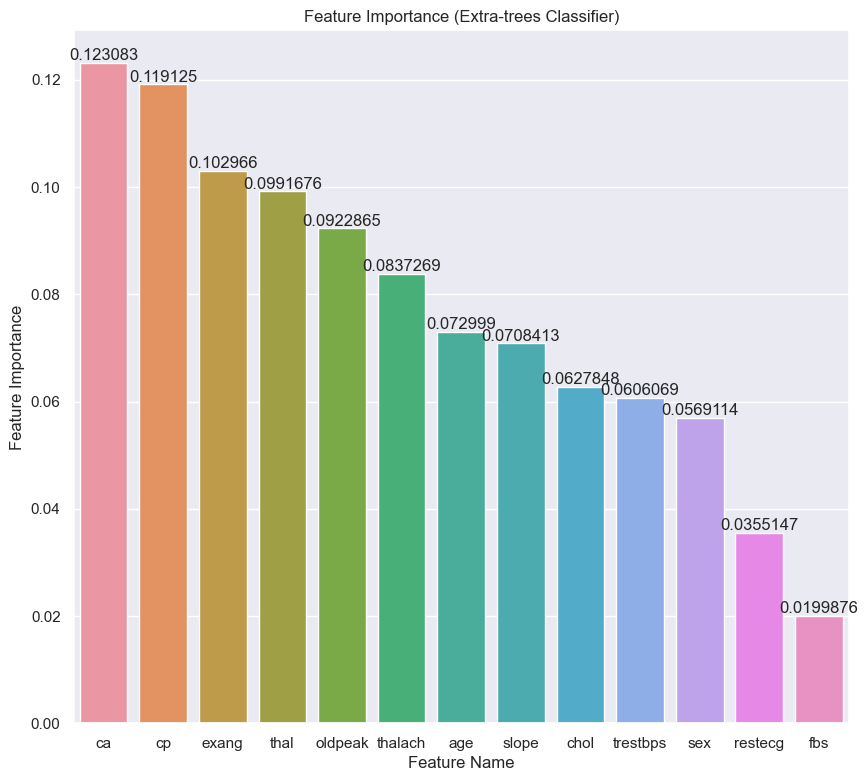

In [26]:
# Plot feature importance scores (positive, sorted)
plot_feature_importance(et_model_feature_importance, df.columns[0:13], pos=True, sort=True, title="Feature Importance (Extra-trees Classifier)")

## Bonus: Univariate feature selection

Let's use univariate feature selection (vs. multivariate feature selection used by LR and ET models) to select the top 5 most important features.

* This analysis is a nice complement to the logistic regression and extra-trees classifier models because, while those are multivariate modeling approaches, this feature selection approach is univariate.

### Key takeaways

* Top 5 most important features include: __thal__, __cp__, __ca__, __exang__, and __oldpeak__

In [27]:
# Identify discrete features (binary, categorical) by index in df
discrete_feat_idx = [1, 2, 5, 6, 8, 10, 11, 12]

# Create custom score function that uses mutual_info_classif - this function can handle discrete and continuous features
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx)

# Instantiate SelectKBest model (identify most important 5 features)
select_kbest = SelectKBest(k=5, score_func=score_func) # Use custom scoring function

# Fit model to data
select_kbest_fit = select_kbest.fit_transform(X, y)

# # Select top 5 most important features identify by the model
select_kbest.get_support()

# # Identify feature names for top 5 most important features
kbest_features = df.columns[0:13][select_kbest.get_support()]

# # Print names of features
print(kbest_features)

Index(['cp', 'exang', 'oldpeak', 'ca', 'thal'], dtype='object')


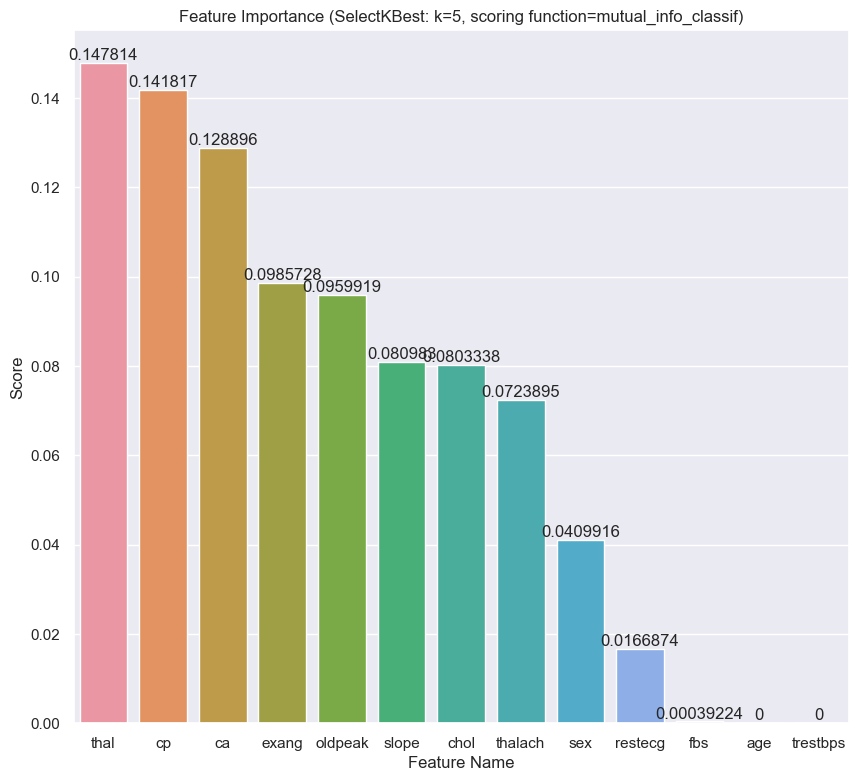

In [28]:
# Draw barplot of features and chi2 score sorted descending by score
select_kbest_scores = pd.DataFrame(select_kbest.scores_, columns=["Score"])
select_kbest_feature_names = pd.DataFrame(df.columns[0:13], columns=["Feature Name"])
select_kbest_feature_names_scores = select_kbest_feature_names.merge(select_kbest_scores, left_index=True, right_index=True)
p = sns.barplot(data=select_kbest_feature_names_scores.sort_values(by="Score", ascending=False), x="Feature Name", y="Score")
plt.title("Feature Importance (SelectKBest: k=5, scoring function=mutual_info_classif)")
for i in p.containers:
    p.bar_label(i,)

### Thank you for reviewing my notebook!

## Deprecated

In [29]:
# # Combine feature importance from LR and ET models into a single dataframe
# df_feature_importance = pd.DataFrame({
#     "Feature Name": df.columns[0:13],
#     "Feature Importance (LR)": lr_model_feature_importance,
#     "Feature Importance (ET)": et_model_feature_importance
# })

# # Rank order the feature importance for the LR model
# df_feature_importance["Feature Importance (LR) Rank"] = np.abs(df_feature_importance["Feature Importance (LR)"]).rank() # Remember to take the absolute value of the feature importance

# # Rank order the feature importance for the ET model
# df_feature_importance["Feature Importance (ET) Rank"] = df_feature_importance["Feature Importance (ET)"].rank()

# # Transform ranks from long to wide dataframe for ploting
# df_feature_importance_rank = df_feature_importance[["Feature Name", "Feature Importance (LR) Rank", "Feature Importance (ET) Rank"]].melt('Feature Name', var_name='Model', value_name='Rank')

# # Plot the transformed dataframe
# p = sns.barplot(data=df_feature_importance_rank, x="Feature Name", y="Rank", hue="Model")
# plt.title("Feature Importance Rank by Model (LR, ET)")
# for i in p.containers:
#     p.bar_label(i,)

In [30]:
# # Compute rank difference between LR and ET models (LR-ET)
# df_feature_importance["Rank Difference (LR-ET)"] = np.abs(df_feature_importance["Feature Importance (LR) Rank"] - df_feature_importance["Feature Importance (ET) Rank"])

# # Plot rank difference
# p = sns.barplot(data=df_feature_importance, x="Feature Name", y="Rank Difference (LR-ET)")
# plt.title("Feature Importance Rank Difference (LR-ET)")
# for i in p.containers:
#     p.bar_label(i,)